In [1]:
import pandas as pd
import numpy as np

mercedes_df=pd.read_csv('Mercedes.csv')
mercedes_df.shape

(4209, 378)

In [2]:
missing_values_df=pd.DataFrame({
    'cloumn_name':mercedes_df.columns,
    'missing_count':mercedes_df.isnull().sum(),
    'missing_value_%':mercedes_df.isnull().sum()/mercedes_df.shape[0]*100
})
missing_values_df.sort_values(by='missing_value_%',ascending=False)
missing_values_df

,cloumn_name,missing_count,missing_value_%
ID,ID,0,0.0
y,y,0,0.0
X0,X0,0,0.0
X1,X1,0,0.0
X2,X2,0,0.0
...,...,...,...
X380,X380,0,0.0
X382,X382,0,0.0
X383,X383,0,0.0
X384,X384,0,0.0


In [3]:
cols_drop=[]

for col in mercedes_df.columns:
    if mercedes_df[col].nunique()==mercedes_df.shape[0] or mercedes_df[col].nunique()==1:
        cols_drop.append(col)
cols_drop

['ID',
 'X11',
 'X93',
 'X107',
 'X233',
 'X235',
 'X268',
 'X289',
 'X290',
 'X293',
 'X297',
 'X330',
 'X347']

In [4]:
mercedes_df.drop(columns=cols_drop,inplace=True)
mercedes_df.shape

(4209, 365)

In [5]:
y=mercedes_df['y']
mercedes_df.drop(columns='y',inplace=True)
mercedes_df.shape

(4209, 364)

In [6]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(mercedes_df,y,test_size=0.2,random_state=43)
print(X_train.shape)
X_train.dtypes

(3367, 364)


X0      object
X1      object
X2      object
X3      object
X4      object
         ...  
X380     int64
X382     int64
X383     int64
X384     int64
X385     int64
Length: 364, dtype: object

In [7]:
from sklearn.preprocessing import LabelEncoder
import numpy as np

import warnings
warnings.filterwarnings('ignore')

class LabelEncoderExt(object):
    def __init__(self):
        """
        It differs from LabelEncoder by handling new classes and providing a value for it [Unknown]
        Unknown will be added in fit and transform will take care of new item. It gives unknown class id
        """
        self.label_encoder = LabelEncoder()
        # self.classes_ = self.label_encoder.classes_

    def fit(self, data_list):
        """
        This will fit the encoder for all the unique values and introduce unknown value
        :param data_list: A list of string
        :return: self
        """
        self.label_encoder = self.label_encoder.fit(list(data_list) + ['Unknown'])
        self.classes_ = self.label_encoder.classes_

        return self

    def transform(self, data_list):
        """
        This will transform the data_list to id list where the new values get assigned to Unknown class
        :param data_list:
        :return:
        """
        new_data_list = list(data_list)
        for unique_item in np.unique(data_list):
            if unique_item not in self.label_encoder.classes_:
                new_data_list = ['Unknown' if x==unique_item else x for x in new_data_list]

        return self.label_encoder.transform(new_data_list)
    
le=LabelEncoderExt()

for col in X_train.columns:
    if X_train[col].dtype=='object':
        le.fit(X_train[col])
        X_train[col]=le.transform(X_train[col])
        X_test[col]=le.transform(X_test[col])


In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca=PCA()
X_train_pca_df=pd.DataFrame(pca.fit_transform(X_train))
X_train_pca_df

pca.explained_variance_ratio_#by default it is in decreasing order

array([3.87077848e-01, 2.04695043e-01, 1.33507682e-01, 1.13655935e-01,
       9.72990039e-02, 1.68663507e-02, 7.82506512e-03, 4.64671164e-03,
       3.11868287e-03, 2.71869647e-03, 2.47986657e-03, 2.14524941e-03,
       1.81081694e-03, 1.59658517e-03, 1.39266225e-03, 1.11371506e-03,
       1.02992580e-03, 9.51888395e-04, 8.46869541e-04, 7.61137504e-04,
       7.02399051e-04, 6.69661589e-04, 6.10352029e-04, 5.47780705e-04,
       5.31183216e-04, 4.64819244e-04, 4.43316997e-04, 3.97939980e-04,
       3.86775360e-04, 3.82933201e-04, 3.52634396e-04, 3.36812548e-04,
       3.14289589e-04, 2.97231255e-04, 2.85672760e-04, 2.70137324e-04,
       2.36465416e-04, 2.28807157e-04, 2.19710097e-04, 2.12318795e-04,
       2.00185530e-04, 1.93699892e-04, 1.89657238e-04, 1.86706199e-04,
       1.84768786e-04, 1.66134502e-04, 1.61246896e-04, 1.56299406e-04,
       1.50220934e-04, 1.47955004e-04, 1.42683753e-04, 1.38180189e-04,
       1.31258521e-04, 1.28444045e-04, 1.24991632e-04, 1.15598521e-04,
      

Text(0, 0.5, 'Explained Variance Ratio')

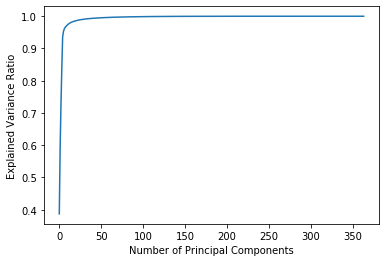

In [9]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance Ratio')

In [10]:
pca_1=PCA(n_components=50)

X_train_pca_df=pd.DataFrame(pca_1.fit_transform(X_train),columns=list(range(0,50)))

X_test_pca_df=pd.DataFrame(pca_1.transform(X_test))

In [11]:
X_train_pca_df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,12.505302,-5.536740,-1.601802,-3.800329,8.513819,5.549673,3.781009,-1.065411,1.954182,0.263205,...,-0.414960,-0.540063,0.159825,-0.561455,-0.591643,-0.667176,-0.514431,0.497746,-0.155711,-0.125032
1,-19.068982,-5.838324,-5.007791,-1.476333,7.966587,4.151217,-3.147848,1.053313,1.313184,-0.113665,...,-0.089115,0.046879,0.330441,-0.317369,-0.239434,-0.087140,-0.235806,0.128520,-0.082468,0.040093
2,-17.626299,2.920037,-6.134081,-3.304791,-11.320752,4.038035,-0.253005,-2.359874,-0.642234,0.182977,...,-0.115652,-0.281176,-0.225247,0.250679,-0.128310,-0.014779,0.169326,0.213828,-0.012940,0.234392
3,-9.756836,1.938110,6.497741,15.187609,-4.752861,-2.310093,-0.773282,-2.875658,-1.126224,-0.027643,...,-0.264794,0.051965,-0.205813,0.041633,0.005261,0.097404,0.182301,0.252294,-0.238663,-0.171536
4,8.888214,-3.344196,-7.042956,6.490240,-0.705797,-4.646400,1.338052,-0.758215,3.214721,1.125037,...,-0.041552,-0.095417,0.320636,0.199160,0.057732,-0.081918,0.278847,0.212931,0.115255,0.288103
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3362,17.378942,-11.684562,7.576810,3.261916,6.976584,-2.864781,2.915882,1.185084,-0.977330,2.448740,...,0.010124,-0.276220,0.576607,-0.463570,-0.589372,0.258023,-0.907221,-0.241384,0.214452,-0.444801
3363,21.048888,15.813648,-2.084245,-4.180605,3.738780,4.096444,0.884145,1.633905,-1.579851,5.153544,...,0.164739,-0.075723,-0.003323,0.142553,-0.087116,0.069872,-0.087892,0.088092,-0.064914,0.043610
3364,27.480841,14.686595,4.479955,-0.177191,-6.245758,3.730780,1.733756,-0.180066,0.343897,-1.364089,...,0.051013,0.213840,0.228102,-0.306246,0.198723,0.096911,-0.051003,-0.017788,0.119015,-0.030151
3365,12.340928,-12.103521,10.208115,1.967088,10.480981,-1.599166,1.516037,0.387668,-0.578929,-1.003416,...,0.379632,-0.855942,0.329376,0.780815,0.133084,-0.237609,-0.258275,-0.073020,0.289322,0.036384


In [12]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif=pd.DataFrame()
vif['VIF Factor']=[variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
vif['columns Name']=X_train.columns
vif.sort_values(by='VIF Factor',ascending=False)



,VIF Factor,columns Name
179,inf,X189
145,inf,X154
226,inf,X239
224,inf,X237
223,inf,X236
...,...,...
180,NaN,X190
193,NaN,X204
196,NaN,X207
246,NaN,X259


In [13]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_pca=pd.DataFrame()
vif_pca['VIF Factor']=[variance_inflation_factor(X_train_pca_df.values,i) for i in range(X_train_pca_df.shape[1])]
vif_pca['columns Name']=X_train_pca_df.columns
vif_pca.sort_values(by='VIF Factor',ascending=False)
vif_pca


,VIF Factor,columns Name
0,1.0,0
1,1.0,1
2,1.0,2
3,1.0,3
4,1.0,4
5,1.0,5
6,1.0,6
7,1.0,7
8,1.0,8
9,1.0,9


In [25]:
X_train_pca_df.to_csv('pca_data_beforeScaling.csv')

In [26]:
import scipy.stats as stats
from scipy.stats import randint

columns = []
print ("cName","\t", "PearSon Coree","\t\t", "pvalue","\n")
for col in X_train_pca_df.columns:
    corre, pvalue = stats.pearsonr(X_train_pca_df[col], y_train)
    
    if (pvalue < 0.03):
        print (col,"\t", corre*100,"\t", pvalue)
        columns.append(col)
print("\n No of PCAs Highly Correlate with Target Veriable: ==>:", len(columns), "Outof_Available PCAs",X_train_pca_df.shape[1])

cName 	 PearSon Coree 		 pvalue 

0 	 18.60370530666425 	 1.3424750382347839e-27
2 	 -9.468598378784543 	 3.700795689875861e-08
6 	 15.587281847803869 	 9.290485894549192e-20
7 	 -30.501596262885304 	 1.9912182086455923e-73
8 	 -5.656407765551525 	 0.0010249416693075791
9 	 28.651258334047675 	 1.2343572920262336e-64
10 	 4.686940758759068 	 0.006525773254789528
11 	 -28.961160309390987 	 4.6146421258381306e-66
12 	 8.482083919082385 	 8.2711471350834e-07
13 	 -19.033507672367318 	 7.811267839875833e-29
15 	 8.504432140465406 	 7.736808249718722e-07
16 	 33.78944325425558 	 1.055545037310971e-90
19 	 4.280169512723984 	 0.01299811148488987
21 	 3.9052336650162696 	 0.02344720460980489
22 	 7.1016021010766135 	 3.716325114721876e-05
24 	 4.781723226409993 	 0.005516894974966958
27 	 -4.096705495977494 	 0.017441612756204053
32 	 -7.535946096629184 	 1.2010403145800351e-05
44 	 -4.563907803945256 	 0.008081556533735384
47 	 -4.034574522982272 	 0.019222879249750444

 No of PCAs Highly Co

In [27]:
X_train_pca_df_final = X_train_pca_df[columns]
X_test_pca_df_final = X_test_pca_df[columns]

In [28]:
from sklearn.preprocessing import MinMaxScaler

mMS = MinMaxScaler()
for col in X_test_pca_df_final.columns:
    X_train_pca_df_final[col] = mMS.fit_transform(np.array(X_train_pca_df_final[col]).reshape(-1,1))
    X_test_pca_df_final[col] = mMS.transform(np.array(X_test_pca_df_final[col]).reshape(-1,1))

In [29]:
X_train_pca_df_final.to_csv('pca_data_afterscaling.csv')

In [30]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor

from sklearn.metrics import r2_score,mean_squared_error

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score,mean_squared_error

LinReg=LinearRegression()
LinReg.fit(X_train_pca_df_final,y_train)

y_linereg_pred=LinReg.predict(X_test_pca_df_final)

print('LR-->r2_score--->',r2_score(y_test,y_linereg_pred))
print('LR-->mean_sqr_score--->',mean_squared_error(y_test,y_linereg_pred))

LR-->r2_score---> 0.5000818605466436
LR-->mean_sqr_score---> 76.36316224335317


In [36]:
model={
    'LR':LinearRegression(),
    'Randomforest':RandomForestRegressor(),
    'Decesiontree':DecisionTreeRegressor(),
    'adaboost':AdaBoostRegressor()
}

In [41]:
rfr=RandomForestRegressor(n_estimators=100,max_depth=10,min_samples_split=2,min_samples_leaf=1)
rfr.fit(X_train_pca_df_final,y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

In [42]:
rfr_predict=rfr.predict(X_test_pca_df_final)
#rfc_predict

In [43]:
print('Model:lr')
print('trainaccuracy:',rfr.score(X_train_pca_df_final,y_train))
print('testaccuracy:',rfr.score(X_test_pca_df_final,y_test))
print('meansqr_score:',mean_squared_error(y_test,rfr_predict))

Model:lr
trainaccuracy: 0.7646672996390765
testaccuracy: 0.4731309544979708
meansqr_score: 80.47994907059369


In [20]:
dt=DecisionTreeRegressor(max_depth=1,min_samples_split=2,min_samples_leaf=1)
dt.fit(X_test_pca_df,y_train)

ValueError: Number of labels=3367 does not match number of samples=842

In [ ]:
for mmodel,nmodel in model.items():
    
    obj=model[mmodel]
    obj.fit(X_train_pca_df,y_train)
    y_predict=obj.predict(X_test_pca_df)#got y_predict and test y_predict with y_test
    
    train_accuracy=obj.score(X_train_pca_df,y_train)
    test_accuracy=obj.score(X_test_pca_df,y_test)
    r2score=r2_score(y_test, y_predict)
    meansqr=mean_squared_error(y_test,y_predict)
    

    print("Model Name: ", mmodel)
    print('trainaccuracy:',train_accuracy)
    print('testaccuracy:',test_accuracy)
    print('r2score:',r2score)
    print('meansqr_score:',meansqr)
    print("\n\n")

